In [1]:
##anything with two ## is something I commented/something I wrote/changed

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv


Welcome! In this notebook, I will be going through a complete data science workflow starting with data cleaning, EDA, and various model interations! Enjoy!

**Model Results**

|Model|AUC Score|
|---|---|
|Baseline - Logistic Regression using TFIDF data| 0.58|
|Logistic Regression using Count Vectorizer Data| 0.55|
|KNN| 0.58|
|SVC| 0.53|
|Random Forest| 0.52|
|Neural Network - MLPClassifier w/ 'lbfgs'| 0.69|
|**Neural Network - MLPClassifer w/ 'adam'**|**0.727**|

In [2]:
#importing the holy trinity of data science packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#Other visualization packages
import seaborn as sns

#Importing NLP plugins
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer 
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Importing our Sklearn Plugins
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#importing our models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#Model Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Part 1: Data Cleaning

In [3]:
df = pd.read_csv("../input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")
df.shape

(17880, 18)

In [4]:
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


## Data Dicitonary
There are 17880 rows with 18 features.

|Column/Feature|Discription|
|---|---|
|job_id|Unique Job ID|
|title|The title of the job ad entry.|
|location|Geographical location of the job ad.|
|department|Corporate department (e.g. sales).|
|salary_range|Indicative salary range (e.g. $50,000-$60,000)|
|company_profile|A brief company description.|
|description|The details description of the job ad.|
|requirment|Enlisted requirements for the job opening.|
|benefits|Enlisted offered benefits by the employer.|
|telecommuting|True for telecommuting positions.|
|has_company_logo|True if company logo is present.|
|has_questions|True if screening questions are present.|
|employment_type|Full-type, Part-time, Contract, etc.|
|required_experience|Executive, Entry level, Intern, etc.|
|required_education|Doctorate, Master’s Degree, Bachelor, etc.|
|industry|Automotive, IT, Health care, Real estate, etc.|
|function|Consulting, Engineering, Research, Sales etc.|
|fradulent|target - Classification attribute.|

**Target Variable** = fradulent (1 or 0) with 1 being fradulent

In [5]:
#Checking our Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
job_id                 17880 non-null int64
title                  17880 non-null object
location               17534 non-null object
department             6333 non-null object
salary_range           2868 non-null object
company_profile        14572 non-null object
description            17879 non-null object
requirements           15185 non-null object
benefits               10670 non-null object
telecommuting          17880 non-null int64
has_company_logo       17880 non-null int64
has_questions          17880 non-null int64
employment_type        14409 non-null object
required_experience    10830 non-null object
required_education     9775 non-null object
industry               12977 non-null object
function               11425 non-null object
fraudulent             17880 non-null int64
dtypes: int64(5), object(13)
memory usage: 2.5+ MB


In [6]:
#Check percentage of data missing for each feature/column
df.isna().sum()/len(df)

job_id                 0.000000
title                  0.000000
location               0.019351
department             0.645805
salary_range           0.839597
company_profile        0.185011
description            0.000056
requirements           0.150727
benefits               0.403244
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
employment_type        0.194128
required_experience    0.394295
required_education     0.453300
industry               0.274217
function               0.361018
fraudulent             0.000000
dtype: float64

In [7]:
#Checking for unique elements for each column
df.nunique()

job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

Just from a quick glance my data, it seems that there is quite a few features that have a lot of missing rows. As such, **I will delete the various columns:**

1. job_id because my DataFrame already has a built in index. 
2. salary_range because around 84% of the data is missing
3. department because around 65% of the data is missing
4. benefits because 40% of the data is missing
5. company_profile because I want to combine the description + requirements columns to one features, in order to perform a tfidf vectorizer on it later on. 

The rest of the columns will be filled out in a methedolical order. 

In [8]:
# Always good practice to make a copy of your dataframe ever so often,
# so you can roll back your mistakes much easier than rerunning your whole kernal again.
df_2 = df.copy()
df_2 = df_2.drop(labels = ['job_id','salary_range',
                    'department','benefits',
                    'company_profile'], axis = 1) #axis = 1 to refer droping columns

In [9]:
df_2.tail(3)

,title,location,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,Graphic Designer,"NG, LA, Lagos",Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0
17879,Web Application Developers,"NZ, N, Wellington",Who are we?Vend is an award winning web based ...,We want to hear from you if:You have an in-dep...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Engineering,0


Filling missing values for **employment_type**, **required_experience**, **required_education**, **industry**, **function** using the pandas bfill function. I did this because these features had the fewest unique elements for a non-binary feature.

> *Pandas bfill is a function that is used with the fillna function to back fill the values in a dataframe. Thus, if there is a NaN cell then bfill will replace that NaN value with the next row or column based on the axis equaling to 0 or 1.*

In [10]:
df_2['employment_type'] = df_2['employment_type'].bfill(axis=0)
df_2['required_experience'] = df_2['required_experience'].bfill(axis = 0)
df_2['required_education'] = df_2['required_education'].bfill(axis = 0)
df_2['industry'] = df_2['industry'].bfill(axis = 0)
df_2['function'] = df_2['function'].bfill(axis = 0)

Next step is to append the *description* column and *requirments* column together into one column. However, before I do this, **I want to avoid the NaN values in both of these columns.** In order to do so since there is a small number of missing rows in the description column, I will drop those rows first. From there, I will fill in all NaN values in the *requirments* column with " " aka. blank string. 

In addition I will drop duplicated description columns as well, prior to the great concatenation. 

In [11]:
# Make Dataframe copy
df_3 = df_2.copy()

# Keeping non NaN rows in my new dataframe
df_3 = df_3[df_3['description'].notna()]

# Replacing NaNs with an empty string.
#df_3 = df_3.replace(np.nan, '', regex = True)

In [12]:
# For good measure let's drop any other Nans 
df_3 = df_3.dropna(axis = 0, how = 'any')

In [13]:
print(f'We currenlty have {len(df_3)} rows. However, let\'s drop duplicates and compare.')

We currenlty have 15014 rows. However, let's drop duplicates and compare.


In [14]:
# drop duplicates
df_3 = df_3.drop_duplicates(keep = 'first')

In [15]:
df_3.isna().sum()/len(df)

title                  0.0
location               0.0
description            0.0
requirements           0.0
telecommuting          0.0
has_company_logo       0.0
has_questions          0.0
employment_type        0.0
required_experience    0.0
required_education     0.0
industry               0.0
function               0.0
fraudulent             0.0
dtype: float64

In [16]:
print(f'After dropping duplicates we have {len(df_3)} rows left. It seems there were 178 duplicate rows.')

After dropping duplicates we have 14836 rows left. It seems there were 178 duplicate rows.


In [17]:
# Make copy
df_4 = df_3.copy()

#concatenating our description and requirments columns
df_4['description'] = df_4['description'] + ' ' + df_4['requirements']
del df_4['requirements']

In [18]:
#Clean DataFrame
df_clean = df_4.copy()

display(df_clean.head(7))
print(df_clean.shape)

,title,location,description,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York","Food52, a fast-growing, James Beard Award-winn...",0,1,0,Other,Internship,Bachelor's Degree,Marketing and Advertising,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Organised - Focused - Vibrant - Awesome!Do you...,0,1,0,Full-time,Not Applicable,Bachelor's Degree,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever","Our client, located in Houston, is actively se...",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
3,Account Executive - Washington DC,"US, DC, Washington",THE COMPANY: ESRI – Environmental Systems Rese...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",JOB TITLE: Itemization Review ManagerLOCATION:...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
6,Head of Content (m/f),"DE, BE, Berlin",Your Responsibilities: Manage the English-spea...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,Lead Guest Service Specialist,"US, CA, San Francisco",Who is Airenvy?Hey there! We are seasoned entr...,0,1,1,Full-time,Associate,High School or equivalent,Information Technology and Services,Customer Service,0


(14836, 12)


# Part 2 - Exploratory Data Analysis

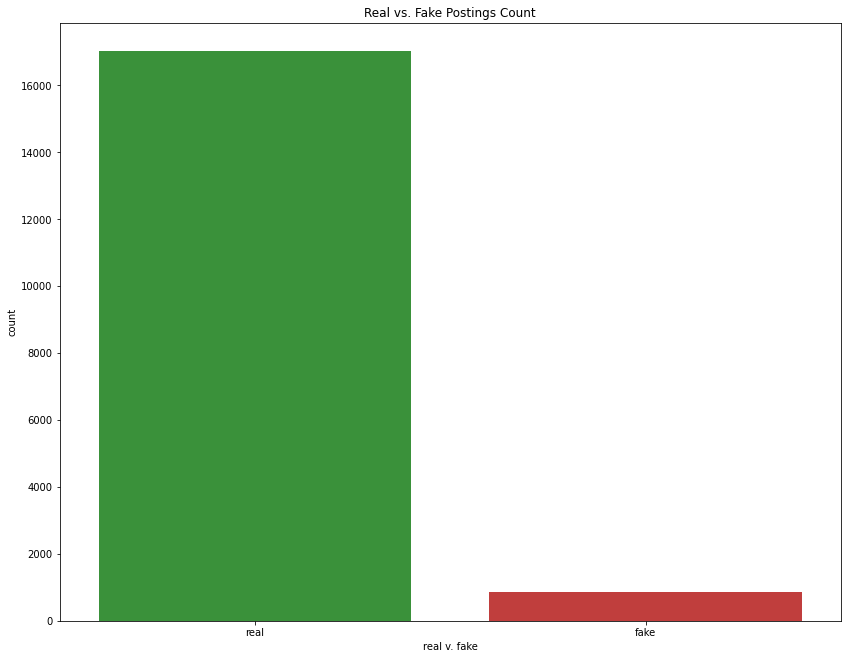

In [19]:
sns.set_palette(sns.color_palette(["#2CA02B", "#D62827"])) ##set a clear universal color palette 
#Plotting the Target variable
fraudulent = plt.figure(figsize = (14,11)) ##increased figure size
fraudulent = sns.countplot(x = df.fraudulent, data = df)
plt.title('Real vs. Fake Postings Count') ##changed from 'Fradulent (Target Variable) Count'
plt.xlabel("real v. fake") ##changed x axis label
fraudulent.set_xticklabels(["real", "fake"]) ##added labels for each of the bars
plt.show() 

It is clear that our data is highly imbalanced. This may cause some difficulties when modeling with highly imbalanced data. 

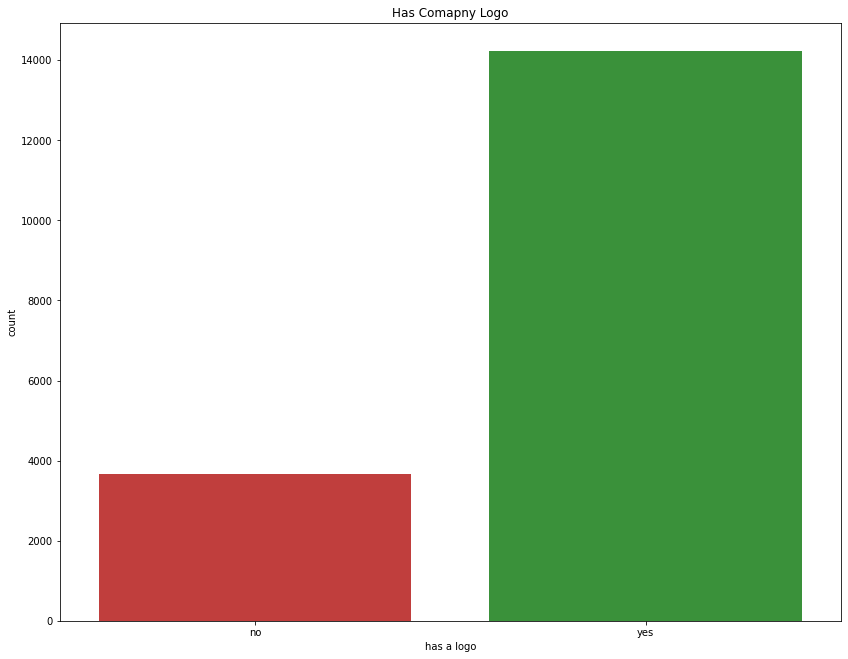

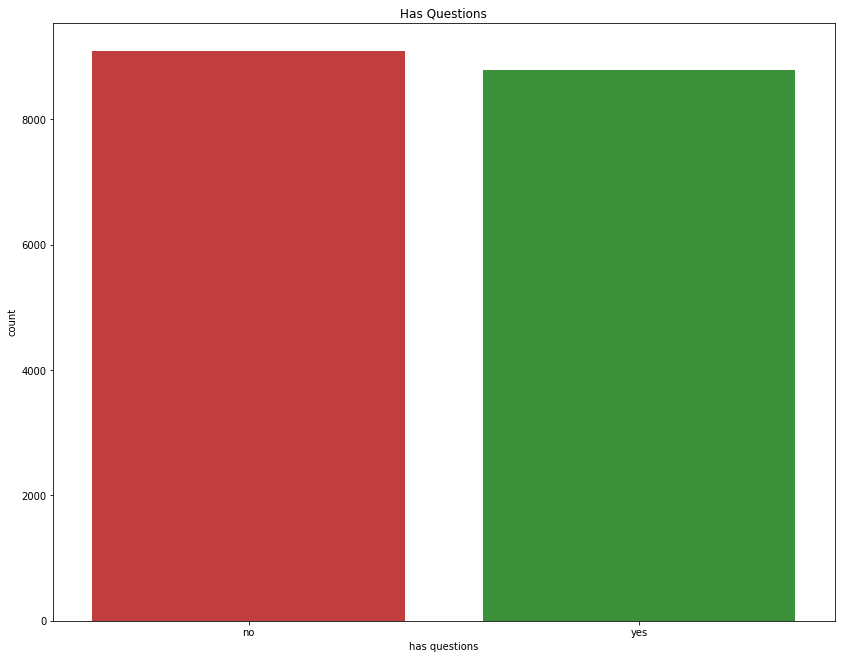

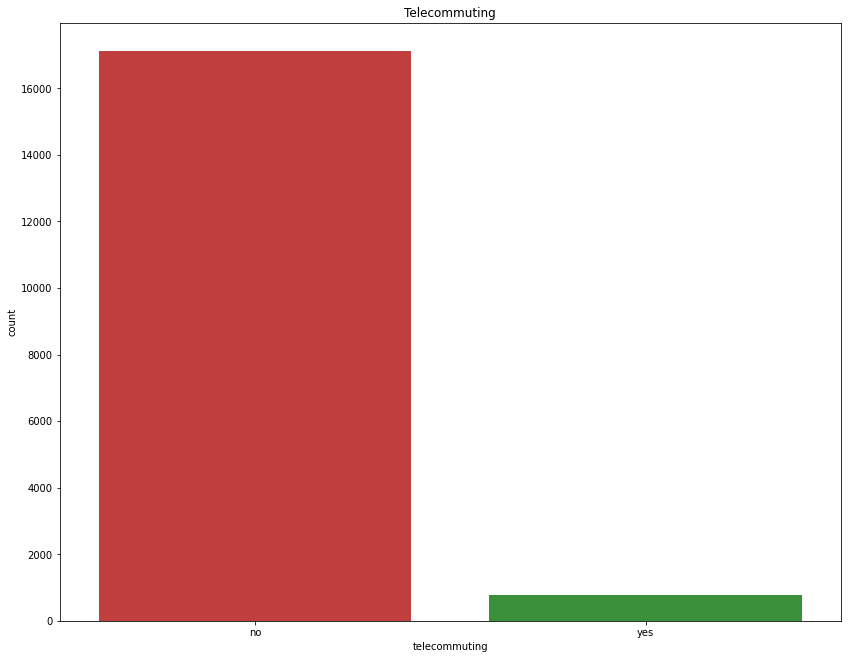

In [20]:
sns.set_palette(sns.color_palette(["#D62827","#2CA02B"])) ##set a clear universal color palette 
#made plots for other data categories
##added labels for the bars
all_logo = plt.figure(figsize = (14,11)) ##increased figure size
all_logo = sns.countplot(x = df.has_company_logo, data = df)
plt.title('Has Comapny Logo') 
plt.xlabel('has a logo')
all_logo.set_xticklabels(["no", "yes"])

all_questions = plt.figure(figsize = (14,11)) #increased figure size
all_questions = sns.countplot(x = df.has_questions, data = df)
plt.title('Has Questions') 
plt.xlabel('has questions')
all_questions.set_xticklabels(["no", "yes"])

all_telecommuting = plt.figure(figsize = (14,11)) #increased figure size
all_telecommuting = sns.countplot(x = df.telecommuting, data = df)
plt.title('Telecommuting') 
plt.xlabel('telecommuting')
all_telecommuting.set_xticklabels(["no", "yes"])

plt.show()

In [21]:
##sort data based on the fraudulent column to then be able to split into two separate dataframes
sorted_data = df.sort_values('fraudulent')

##find row where postings shift from real to fraudulent
count = 0
for index in sorted_data.fraudulent:
    if index == 1:
        break
    else:
        count+=1
        
##split data into two separate dataframes, one for fraudulent postings, one for real postings
not_fraudulent_data = sorted_data.iloc[:count]
fraudulent_data = sorted_data.iloc[count:]

fraud and logo: 32.67898383371824
fraud no logo: 67.32101616628175
no fraud and logo: 81.91489361702128
no fraud no logo: 18.085106382978726


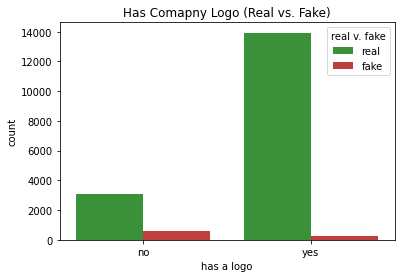

In [22]:
sns.set_palette(sns.color_palette(["#2CA02B", "#D62827"])) ##set a clear universal color palette 
##comparison for fake/real postings based on if posting has company logo
logo = sns.countplot(data=df, x="has_company_logo", hue="fraudulent")
plt.title('Has Comapny Logo (Real vs. Fake)') 
plt.xlabel('has a logo')
logo.legend(title="real v. fake", labels=["real", "fake"])
logo.set_xticklabels(["no", "yes"])

##counts number of fake postings that have a logo and number that don't
fraud_with_logo = 0
fraud_without_logo = 0
total_fraud_logo = 0
for index in fraudulent_data.has_company_logo:
    if index == 1:
        fraud_with_logo += 1
        total_fraud_logo += 1
    elif index == 0:
        fraud_without_logo += 1
        total_fraud_logo += 1

##counts number of real postings that have a logo and number that's don't
not_fraud_with_logo = 0
not_fraud_without_logo = 0
total_not_fraud_logo = 0
for index in not_fraudulent_data.has_company_logo:
    if index == 1:
        not_fraud_with_logo += 1
        total_not_fraud_logo += 1
    elif index == 0:
        not_fraud_without_logo += 1
        total_not_fraud_logo += 1

##calculates percent of fake postings that have logo, percent that do not
fraud_with_logo_percent = (fraud_with_logo/total_fraud_logo)*100
fraud_without_logo_percent = (fraud_without_logo/total_fraud_logo)*100
print("fraud and logo: " + str(fraud_with_logo_percent))
print("fraud no logo: " + str(fraud_without_logo_percent))      
  
##calculates percent of real postings that have logo, percent that do not
not_fraud_with_logo_percent = (not_fraud_with_logo/total_not_fraud_logo)*100
not_fraud_without_logo_percent = (not_fraud_without_logo/total_not_fraud_logo)*100 
print("no fraud and logo: " + str(not_fraud_with_logo_percent))
print("no fraud no logo: " + str(not_fraud_without_logo_percent))

plt.show()

fraud and questions: 28.868360277136258
fraud no questions: 71.13163972286374
no fraud and questions: 50.20571294228282
no fraud no questions: 49.79428705771717


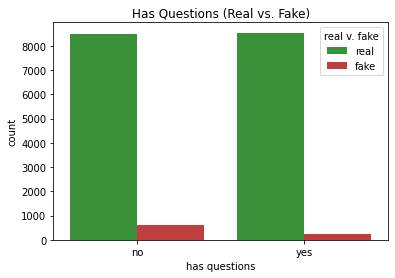

In [23]:
sns.set_palette(sns.color_palette(["#2CA02B", "#D62827"])) ##set a clear universal color palette 
##comparison for fake/real postings based on if posting has questions
questions = sns.countplot(data=df, x="has_questions", hue="fraudulent")
plt.title('Has Questions (Real vs. Fake)') 
plt.xlabel('has questions')
questions.legend(title="real v. fake", labels=["real", "fake"])
questions.set_xticklabels(["no", "yes"])

#c#ounts number of fake postings that have a questions and number that don't
fraud_with_questions = 0
fraud_without_questions = 0
total_fraud_questions = 0
for index in fraudulent_data.has_questions:
    if index == 1:
        fraud_with_questions += 1
        total_fraud_questions += 1
    elif index == 0:
        fraud_without_questions += 1
        total_fraud_questions += 1

##counts number of real postings that have questions and number that's don't
not_fraud_with_questions = 0
not_fraud_without_questions = 0
total_not_fraud_questions = 0
for index in not_fraudulent_data.has_questions:
    if index == 1:
        not_fraud_with_questions += 1
        total_not_fraud_questions += 1
    elif index == 0:
        not_fraud_without_questions += 1
        total_not_fraud_questions += 1

##calculates percent of fake postings that have questions, percent that do not
fraud_with_questions_percent = (fraud_with_questions/total_fraud_questions)*100
fraud_without_questions_percent = (fraud_without_questions/total_fraud_questions)*100
print("fraud and questions: " + str(fraud_with_questions_percent))
print("fraud no questions: " + str(fraud_without_questions_percent))      
  
##calculates percent of real postings that have questions, percent that do not
not_fraud_with_questions_percent = (not_fraud_with_questions/total_not_fraud_questions)*100
not_fraud_without_questions_percent = (not_fraud_without_questions/total_not_fraud_questions)*100 
print("no fraud and questions: " + str(not_fraud_with_questions_percent))
print("no fraud no questions: " + str(not_fraud_without_questions_percent))

plt.show()

fraud and telecommuting: 7.390300230946882
fraud no telecommuting: 92.60969976905312
no fraud and telecommuting: 4.131891383566474
no fraud no telecommuting: 95.86810861643352


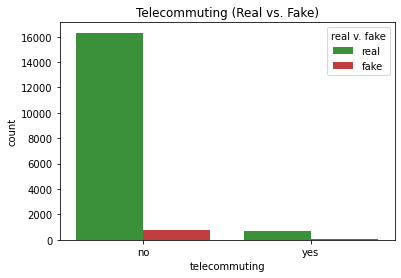

In [24]:
sns.set_palette(sns.color_palette(["#2CA02B", "#D62827"])) ##set a clear universal color palette 
##comparison for fake/real postings based on if posting is telecommuting
telecommuting = sns.countplot(data=df, x="telecommuting", hue="fraudulent")
plt.title('Telecommuting (Real vs. Fake)') 
plt.xlabel('telecommuting')
telecommuting.legend(title="real v. fake", labels=["real", "fake"])
telecommuting.set_xticklabels(["no", "yes"])

##counts number of fake postings that are telecommuting and number that are not
fraud_with_telecommuting = 0
fraud_without_telecommuting = 0
total_fraud_telecommuting = 0
for index in fraudulent_data.telecommuting:
    if index == 1:
        fraud_with_telecommuting += 1
        total_fraud_telecommuting += 1
    elif index == 0:
        fraud_without_telecommuting += 1
        total_fraud_telecommuting += 1

##counts number of real postings that are telecommuting and number that are not
not_fraud_with_telecommuting = 0
not_fraud_without_telecommuting = 0
total_not_fraud_telecommuting = 0
for index in not_fraudulent_data.telecommuting:
    if index == 1:
        not_fraud_with_telecommuting += 1
        total_not_fraud_telecommuting += 1
    elif index == 0:
        not_fraud_without_telecommuting += 1
        total_not_fraud_telecommuting += 1

##calculates percent of fake postings that are telecommuting, percent that are not
fraud_with_telecommuting_percent = (fraud_with_telecommuting/total_fraud_telecommuting)*100
fraud_without_telecommuting_percent = (fraud_without_telecommuting/total_fraud_telecommuting)*100
print("fraud and telecommuting: " + str(fraud_with_telecommuting_percent))
print("fraud no telecommuting: " + str(fraud_without_telecommuting_percent))      
  
##calculates percent of real postings that are telecommuting, percent that are not
not_fraud_with_telecommuting_percent = (not_fraud_with_telecommuting/total_not_fraud_telecommuting)*100
not_fraud_without_telecommuting_percent = (not_fraud_without_telecommuting/total_not_fraud_telecommuting)*100 
print("no fraud and telecommuting: " + str(not_fraud_with_telecommuting_percent))
print("no fraud no telecommuting: " + str(not_fraud_without_telecommuting_percent))

plt.show()

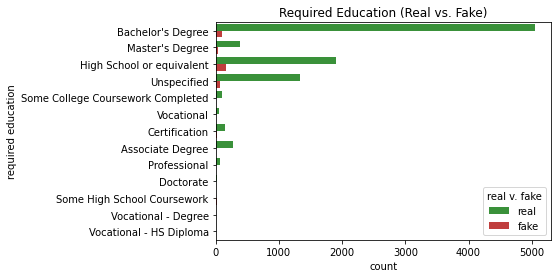

Fake Bachelor's Degree: 25.31645569620253
Real Bachelor's Degree: 53.939912327595415
Fake Master's Degree: 7.848101265822785
Real Master's Degree: 4.116326312413129
Fake High School or equivalent: 43.037974683544306
Real High School or equivalent: 20.421255212231372
Fake Unspecified: 15.443037974683543
Real Unspecified: 14.284186891906339
Fake Some College Coursework Completed: 0.7594936708860759
Real Some College Coursework Completed: 1.0584839089062332
Fake Vocational: 0.0
Real Vocational: 0.5238960761253073
Fake Certification: 4.810126582278481
Real Certification: 1.6144552549983961
Fake Associate Degree: 1.5189873417721518
Real Associate Degree: 2.8653907837057626
Fake Professional: 1.0126582278481013
Real Professional: 0.7484229658932963
Fake Doctorate: 0.25316455696202533
Real Doctorate: 0.26729391639046296
Fake Some High Shcool Coursework: 0.0
Real Some High Shcool Coursework: 0.0
Fake Vocational - Degree: 0.0
Real Vocational - Degree: 0.06415053993371111
Fake Vocational - HS Di

In [25]:
sns.set_palette(sns.color_palette(["#2CA02B", "#D62827"])) ##set a clear universal color palette 
##comparison for fake/real postings based on required edeucation
req_ed = sns.countplot(data=df, y="required_education", hue="fraudulent")
plt.title('Required Education (Real vs. Fake)') 
plt.ylabel('required education')
req_ed.legend(title="real v. fake", labels=["real", "fake"], loc="lower right")
plt.show()

##creates dicictionaries with the required education labels as keys to store counts of each label, and then their percent
required_ed_fraud_counts = {}
required_ed_not_fraud_counts = {}
ed_keys = ["Bachelor's Degree", "Master's Degree", "High School or equivalent", 
        "Unspecified", "Some College Coursework Completed", "Vocational", "Certification", "Associate Degree",
       "Professional", "Doctorate", "Some High Shcool Coursework", "Vocational - Degree", "Vocational - HS Diploma"]
for level in ed_keys:
    required_ed_fraud_counts.setdefault(level, [])
    required_ed_fraud_counts[level].append(0)
    required_ed_not_fraud_counts.setdefault(level, [])
    required_ed_not_fraud_counts[level].append(0)

##counts number of fake postings that belong to which of the 13 required education keys
total_fraud_ed_count = 0
for index in fraudulent_data.required_education:
    for key in required_ed_fraud_counts:
        if index == key:
            required_ed_fraud_counts[key][0] = required_ed_fraud_counts[key][0] + 1
            total_fraud_ed_count += 1

##counts number of real postings that belong to which of the 13 required education keys
total_not_fraud_ed_count = 0
for index in not_fraudulent_data.required_education:
    for key in required_ed_not_fraud_counts:
        if index == key:
            required_ed_not_fraud_counts[key][0] = required_ed_not_fraud_counts[key][0] + 1
            total_not_fraud_ed_count += 1

##calculates the percent that each required education key makes up for fake postings, and then real ones
for key in required_ed_fraud_counts:
    required_ed_fraud_counts[key].append((required_ed_fraud_counts[key][0]/total_fraud_ed_count)*100)
    required_ed_not_fraud_counts[key].append((required_ed_not_fraud_counts[key][0]/total_not_fraud_ed_count)*100)
    print("Fake " + key + ": " + str(required_ed_fraud_counts[key][1]))
    print("Real " + key + ": " + str(required_ed_not_fraud_counts[key][1]))

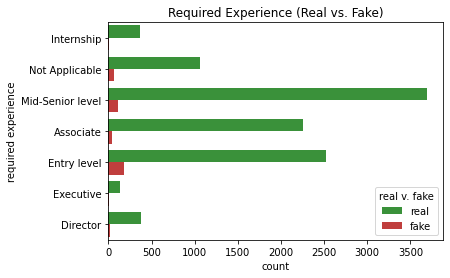

Fake Internship: 2.320185614849188
Real Internship: 3.5676507356476588
Fake Not Applicable: 13.921113689095128
Real Not Applicable: 10.154822579094144
Fake Mid-Senior level: 26.218097447795824
Real Mid-Senior level: 35.541879026829506
Fake Associate: 9.744779582366588
Real Associate: 21.684777382440622
Fake Entry level: 41.53132250580047
Real Entry level: 24.21386671795365
Fake Executive: 2.320185614849188
Real Executive: 1.2597365131262621
Fake Director: 3.944315545243619
Real Director: 3.577267044908164


In [26]:
sns.set_palette(sns.color_palette(["#2CA02B", "#D62827"])) ##set a clear universal color palette 
##comparison for fake/real postings based on required experience
req_exp = sns.countplot(data=df, y="required_experience", hue="fraudulent")
plt.title('Required Experience (Real vs. Fake)') 
plt.ylabel('required experience')
req_exp.legend(title="real v. fake", labels=["real", "fake"], loc="lower right")
plt.show()

##creates dicictionaries with the required experience labels as keys to store counts of each label, and then their percent
required_exp_fraud_counts = {}
required_exp_not_fraud_counts = {}
exp_keys = ["Internship", "Not Applicable", "Mid-Senior level", "Associate", "Entry level", "Executive", "Director"]
for level in exp_keys:
    required_exp_fraud_counts.setdefault(level, [])
    required_exp_fraud_counts[level].append(0)
    required_exp_not_fraud_counts.setdefault(level, [])
    required_exp_not_fraud_counts[level].append(0)

##counts number of fake postings that belong to which of the 7 required experience keys
total_fraud_exp_count = 0
for index in fraudulent_data.required_experience:
    for key in required_exp_fraud_counts:
        if index == key:
            required_exp_fraud_counts[key][0] = required_exp_fraud_counts[key][0] + 1
            total_fraud_exp_count += 1

##counts number of real postings that belong to which of the 7 required experience keys
total_not_fraud_exp_count = 0
for index in not_fraudulent_data.required_experience:
    for key in required_exp_not_fraud_counts:
        if index == key:
            required_exp_not_fraud_counts[key][0] = required_exp_not_fraud_counts[key][0] + 1
            total_not_fraud_exp_count += 1

##calculates the percent that each required experience key makes up for fake postings, and then real ones
for key in required_exp_fraud_counts:
    required_exp_fraud_counts[key].append((required_exp_fraud_counts[key][0]/total_fraud_exp_count)*100)
    required_exp_not_fraud_counts[key].append((required_exp_not_fraud_counts[key][0]/total_not_fraud_exp_count)*100)
    print("Fake " + key + ": " + str(required_exp_fraud_counts[key][1]))
    print("Real " + key + ": " + str(required_exp_not_fraud_counts[key][1]))

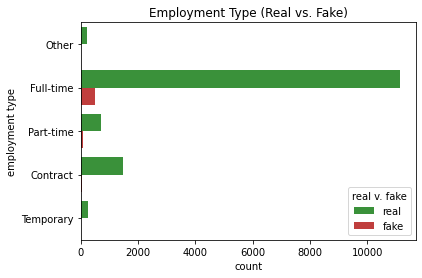

Fake Other: 2.4
Real Other: 1.5380150899593732
Fake Full-time: 78.4
Real Full-time: 80.7457922228671
Fake Part-time: 11.84
Real Part-time: 5.245211839814277
Fake Contract: 7.04
Real Contract: 10.73708647707487
Fake Temporary: 0.32
Real Temporary: 1.7338943702843876


In [27]:
sns.set_palette(sns.color_palette(["#2CA02B", "#D62827"])) ##set a clear universal color palette 
##comparison for fake/real postings based on employment type
employ_type = sns.countplot(data=df, y="employment_type", hue="fraudulent")
plt.title('Employment Type (Real vs. Fake)') 
plt.ylabel('employment type')
employ_type.legend(title="real v. fake", labels=["real", "fake"], loc="lower right")
plt.show()

##creates dicictionaries with the employment type labels as keys to store counts of each label, and then their percent
employ_type_fraud_counts = {}
employ_type_not_fraud_counts = {}
employ_type_keys = ["Other", "Full-time", "Part-time", "Contract", "Temporary"]
for level in employ_type_keys:
    employ_type_fraud_counts.setdefault(level, [])
    employ_type_fraud_counts[level].append(0)
    employ_type_not_fraud_counts.setdefault(level, [])
    employ_type_not_fraud_counts[level].append(0)

##counts number of fake postings that belong to which of the 5 employment type keys
total_fraud_employ_type_count = 0
for index in fraudulent_data.employment_type:
    for key in employ_type_fraud_counts:
        if index == key:
            employ_type_fraud_counts[key][0] = employ_type_fraud_counts[key][0] + 1
            total_fraud_employ_type_count += 1

##counts number of real postings that belong to which of the 5 employment type keys
total_not_fraud_employ_type_count = 0
for index in not_fraudulent_data.employment_type:
    for key in employ_type_not_fraud_counts:
        if index == key:
            employ_type_not_fraud_counts[key][0] = employ_type_not_fraud_counts[key][0] + 1
            total_not_fraud_employ_type_count += 1

##calculates the percent that each employment type key makes up for fake postings, and then real ones
for key in employ_type_fraud_counts:
    employ_type_fraud_counts[key].append((employ_type_fraud_counts[key][0]/total_fraud_employ_type_count)*100)
    employ_type_not_fraud_counts[key].append((employ_type_not_fraud_counts[key][0]/total_not_fraud_employ_type_count)*100)
    print("Fake " + key + ": " + str(employ_type_fraud_counts[key][1]))
    print("Real " + key + ": " + str(employ_type_not_fraud_counts[key][1]))

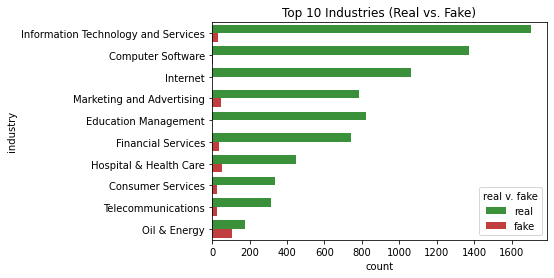

Fake Oil & Energy: 33.33333333333333
Real Oil & Energy: 2.294405774684197
Fake Telecommunications: 7.951070336391437
Real Telecommunications: 4.073214746068574
Fake Consumer Services: 7.339449541284404
Real Consumer Services: 4.305233307553493
Fake Hospital & Health Care: 15.59633027522936
Real Hospital & Health Care: 5.748904356792988
Fake Financial Services: 10.703363914373089
Real Financial Services: 9.590100541376643
Fake Education Management: 0.0
Real Education Management: 10.595514307811293
Fake Marketing and Advertising: 13.761467889908257
Real Marketing and Advertising: 10.092807424593968
Fake Internet: 0.0
Real Internet: 13.68909512761021
Fake Computer Software: 1.529051987767584
Real Computer Software: 17.672080433101314
Fake Information Technology and Services: 9.785932721712538
Real Information Technology and Services: 21.93864398040732


In [28]:
sns.set_palette(sns.color_palette(["#2CA02B", "#D62827"])) ##set a clear universal color palette 
##comparison for fake/real postings based on employment type
industry = sns.countplot(data=df, y="industry", hue="fraudulent", order = df.industry.value_counts().index[:10])
plt.title('Top 10 Industries (Real vs. Fake)') 
plt.ylabel('industry')
industry.legend(title="real v. fake", labels=["real", "fake"], loc="lower right")
plt.show()

##creates dicictionaries with the top 10 industry labels as keys to store counts of each label, and then their percent
industry_fraud_counts = {}
industry_not_fraud_counts = {}
industry_keys = ["Oil & Energy", "Telecommunications", "Consumer Services", "Hospital & Health Care", "Financial Services",
                "Education Management", "Marketing and Advertising", "Internet", "Computer Software", "Information Technology and Services"]
for level in industry_keys:
    industry_fraud_counts.setdefault(level, [])
    industry_fraud_counts[level].append(0)
    industry_not_fraud_counts.setdefault(level, [])
    industry_not_fraud_counts[level].append(0)

##counts number of fake postings that belong to which of the 10 industry keys
total_fraud_industry_count = 0
for index in fraudulent_data.industry:
    for key in industry_fraud_counts:
        if index == key:
            industry_fraud_counts[key][0] = industry_fraud_counts[key][0] + 1
            total_fraud_industry_count += 1
            
##counts number of real postings that belong to which of the 10 industry keys            
total_not_fraud_industry_count = 0
for index in not_fraudulent_data.industry:
    for key in industry_not_fraud_counts:
        if index == key:
            industry_not_fraud_counts[key][0] = industry_not_fraud_counts[key][0] + 1
            total_not_fraud_industry_count += 1

##calculates the percent that each of the top 10 industries' key makes up for fake postings, and then real ones
for key in industry_fraud_counts:
    industry_fraud_counts[key].append((industry_fraud_counts[key][0]/total_fraud_industry_count)*100)
    industry_not_fraud_counts[key].append((industry_not_fraud_counts[key][0]/total_not_fraud_industry_count)*100)
    print("Fake " + key + ": " + str(industry_fraud_counts[key][1]))
    print("Real " + key + ": " + str(industry_not_fraud_counts[key][1]))

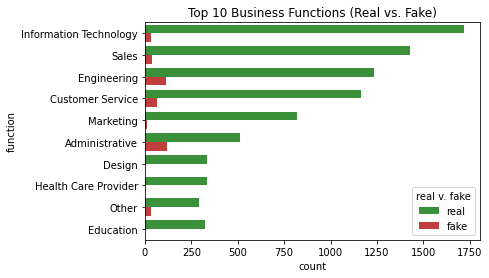

Fake Other: 7.637231503579953
Real Other: 3.5893666544162683
Fake Education: 0.23866348448687352
Real Education: 3.9691289966923926
Fake Health Care Provider: 0.23866348448687352
Real Health Care Provider: 4.128384172485606
Fake Design: 0.7159904534606205
Real Design: 4.128384172485606
Fake Administrative: 28.400954653937948
Real Administrative: 6.259953448487075
Fake Marketing: 2.386634844868735
Real Marketing: 10.045326473110377
Fake Customer Service: 15.990453460620524
Real Customer Service: 14.234962636285678
Fake Engineering: 26.968973747016705
Real Engineering: 15.129241700355262
Fake Sales: 9.785202863961814
Real Sales: 17.48131814283964
Fake Information Technology: 7.637231503579953
Real Information Technology: 21.03393360284209


In [29]:
sns.set_palette(sns.color_palette(["#2CA02B", "#D62827"])) ##set a clear universal color palette 
##comparison for fake/real postings based on employment type
function = sns.countplot(data=df, y="function", hue="fraudulent", order = df.function.value_counts().index[:10])
plt.title('Top 10 Business Functions (Real vs. Fake)') 
plt.ylabel('function')
function.legend(title="real v. fake", labels=["real", "fake"], loc="lower right")
plt.show()

##creates dicictionaries with the top 10 business function labels as keys to store counts of each label, and then their percent
function_fraud_counts = {}
function_not_fraud_counts = {}
function_keys = ["Other", "Education", "Health Care Provider", "Design", "Administrative",
                "Marketing", "Customer Service", "Engineering", "Sales", "Information Technology"]
for level in function_keys:
    function_fraud_counts.setdefault(level, [])
    function_fraud_counts[level].append(0)
    function_not_fraud_counts.setdefault(level, [])
    function_not_fraud_counts[level].append(0)

##counts number of fake postings that belong to which of the 10 business function keys  
total_fraud_function_count = 0
for index in fraudulent_data.function:
    for key in function_fraud_counts:
        if index == key:
            function_fraud_counts[key][0] = function_fraud_counts[key][0] + 1
            total_fraud_function_count += 1

##counts number of real postings that belong to which of the 10 business function keys            
total_not_fraud_function_count = 0
for index in not_fraudulent_data.function:
    for key in function_not_fraud_counts:
        if index == key:
            function_not_fraud_counts[key][0] = function_not_fraud_counts[key][0] + 1
            total_not_fraud_function_count += 1

##calculates the percent that each of the top 10 business functions' key makes up for fake postings, and then real ones
for key in function_fraud_counts:
    function_fraud_counts[key].append((function_fraud_counts[key][0]/total_fraud_function_count)*100)
    function_not_fraud_counts[key].append((function_not_fraud_counts[key][0]/total_not_fraud_function_count)*100)
    print("Fake " + key + ": " + str(function_fraud_counts[key][1]))
    print("Real " + key + ": " + str(function_not_fraud_counts[key][1]))

### EDA Insights

* Most job offers were Full-time, followed by Contract work.

* Most jobs required an experience of mid-senior level, followed closely by Entry Level and Associate Level. Which is similar. 

* Most education experience required is a Bachelor’s Degree, with very few requiring Master’s Degree. Which signals that **work experience matters more** than education experience, and that the bachelor degree is a piece paper that proves you’ve done something. 

* In this dataset, The top 3 Industries were all tech related.

* The top 3 business functions were Information Technology, Sales, and Engineering.


#### Future Plots
1. A couple of word cloud images, people for some reason love world clouds.
2. Plot of a map, showing the counts of jobs for each country. etc.

In [30]:
#Make Copy
df_5 = df_clean.copy()
##changed parameter that was dropped, in following line, for every removed parameter discussed in paper 
#d#f_5 = df_5.drop("has_questions", axis=1)

# One Hot Encoding using Pandas get dummies function
##removed and added back in these parameters depending on what parameter was being removed
columns_to_1_hot = ['function','required_education','employment_type', 'industry', 'required_experience']

for column in columns_to_1_hot:
    encoded = pd.get_dummies(df_5[column])
    df_5 = pd.concat([df_5, encoded], axis = 1)


In [31]:
columns_to_1_hot += ['title', 'location']
    
#droping the original columns that we just one hot encoded from
df_5 = df_5.drop(columns_to_1_hot, axis = 1)

In [32]:
df_5.head()

,description,telecommuting,has_company_logo,has_questions,fraudulent,Accounting/Auditing,Administrative,Advertising,Art/Creative,Business Analyst,...,Wine and Spirits,Wireless,Writing and Editing,Associate,Director,Entry level,Executive,Internship,Mid-Senior level,Not Applicable
0,"Food52, a fast-growing, James Beard Award-winn...",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Organised - Focused - Vibrant - Awesome!Do you...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,"Our client, located in Houston, is actively se...",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,THE COMPANY: ESRI – Environmental Systems Rese...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,JOB TITLE: Itemization Review ManagerLOCATION:...,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Handling the description column 

First of all we need to clean up our text data a little bit. Now let us creat some helper funcitons.

In [33]:
def tokenizer(text):
    
    #All characters in this string will be converted to lowercase
    text = text.lower()
    
    #Removing sentence punctuations
    for punctuation_mark in string.punctuation:
        text = text.replace(punctuation_mark,'')
    
    #Creating our list of tokens
    list_of_tokens = text.split(' ')
    #Creating our cleaned tokens list 
    cleaned_tokens = []
    #Intatiating our Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    #Removing Stop Words in our list of tokens and any tokens that happens to be empty strings
    for token in list_of_tokens:
        if (not token in stop_words) and (token != ''):
            #lemmatizing our token
            token_lemmatized = lemmatizer.lemmatize(token)
            #appending our finalized cleaned token
            cleaned_tokens.append(token_lemmatized)
    
    return cleaned_tokens

## TfidfVectorizer

I will need to run a tfidf vectorizer on our description data, and append the results to our DataFrame. 

In [34]:
df_6 = df_5.copy()

#Instatiating our tfidf vectorizer
tfidf = TfidfVectorizer(tokenizer = tokenizer, min_df = 0.05, ngram_range=(1,3))
#Fit_transform our description 
tfidf_features = tfidf.fit_transform(df_6['description']) #this will create a sparse matrix

In [35]:
#I want to append this sparse matrix to the original pandas Dataframe
tfidf_vect_df = pd.DataFrame(tfidf_features.todense(), columns = tfidf.get_feature_names())

df_tfidf = pd.concat([df_6, tfidf_vect_df], axis = 1)

#Minor Cleaning steps after appending our tfidf results to our Dataframe, we will need to drop the description column. 
df_tfidf = df_tfidf.drop(['description'], axis = 1)
df_tfidf = df_tfidf.dropna()

In [36]:
df_tfidf.head(3)

,telecommuting,has_company_logo,has_questions,fraudulent,Accounting/Auditing,Administrative,Advertising,Art/Creative,Business Analyst,Business Development,...,write,writing,written,written communication,written verbal,year,year experience,you’ll,,–
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Count Vectorizer
Now let's do a similar procedure with a Count Vectorizer, so we can compare the two vectorizers in performance later on.

In [37]:
#Instatiating our CountVectorizer
count_vect = CountVectorizer(tokenizer = tokenizer, min_df = 0.05, ngram_range=(1,3))
#Fit_transform our description 
count_vect_features = count_vect.fit_transform(df_6['description']) #this will create a sparse matrix

count_vect_df = pd.DataFrame(count_vect_features.todense(), columns = count_vect.get_feature_names())

df_count_vect = pd.concat([df_6, count_vect_df], axis = 1)
df_count_vect = df_count_vect.drop(['description'], axis = 1)
df_count_vect = df_count_vect.dropna()

In [38]:
df_count_vect.head(3)

,telecommuting,has_company_logo,has_questions,fraudulent,Accounting/Auditing,Administrative,Advertising,Art/Creative,Business Analyst,Business Development,...,write,writing,written,written communication,written verbal,year,year experience,you’ll,,–
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Great, we now have two different dataframes with two different vectorizers preprocessing our description data. I will hold out on the PCA to see if I need it. I will only do it if the modelimg takes too long. 

**I will conduct the following steps:**
1. Logistic Regression w/ Tfidf
2. Logistic Regression w/ Count Vectorizer
3. I will evaluate both models and determine which is better, and for simplicity stake pick the superior vectorizer for the other models I would like to run.

# Model 1 - Logistic Regresion w/ Tfidf

In [39]:
target = df_tfidf.fraudulent
features = df_tfidf.drop(['fraudulent'], axis = 1)
    

#Spliting our Data into train and holdout sets to test our models
X_train, X_hold, y_train, y_hold = train_test_split(features, target, test_size = 0.1,
                                                    stratify = target, random_state = 42)

Interesting, using our holdout data our logistic regression with the tfidf data, had an AUC score of 0.58. Which is okay, that will be our baseline model. 

# Model 7 - Neural Nets - MLPClassifier w/ solver = 'adam'

In [40]:
#Instatiatie our MLPClassifier
mlp = MLPClassifier(solver='adam', 
                    activation = 'relu',
                   hidden_layer_sizes = (100,50,30), 
                    max_iter = 1000)

In [41]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 30), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [42]:
mlp_pred = mlp.predict(X_hold)

#Printing out our evaluation metrics
print(roc_auc_score(y_hold, mlp_pred))
print(classification_report(y_hold, mlp_pred))

0.6943299369993
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1196
         1.0       0.68      0.40      0.50        43

    accuracy                           0.97      1239
   macro avg       0.83      0.69      0.74      1239
weighted avg       0.97      0.97      0.97      1239



Using the adam solver made our model perform even better! **an AUC score of 0.72! **